# Ross Ice Shelf gravity reduction

# Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
import zarr
from polartoolkit import fetch, maps, regions
from polartoolkit import utils as polar_utils

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"
logging.getLogger().setLevel(logging.INFO)
from invert4geom import regional, utils

# Set region and parameters

In [2]:
starting_region = [-580e3, 420e3, -1420e3, -420e3]

inversion_region = starting_region
buffer_region = vd.pad_region(starting_region, 40e3)

# set densities
air_density = 1
ice_density = 915  # +/- 5, from Griggs and Bamber 2009/2011
water_density = 1024  # +/- 5, from Griggs and Bamber 2009/2011
sediment_density = 2300  # will likely change this

# set layer parameters
layer_spacing = 5e3
registration = "g"

# set gravity observation parameters
grav_observation_height = 1e3
grav_spacing = 5e3

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

layer spacing: 5000.0m
registration: g
inversion region =  [-580000.0, 420000.0, -1420000.0, -420000.0]
buffer region =  (-620000.0, 460000.0, -1460000.0, -380000.0)


# Load data

## topographic layers
* Surface, Icebase, Bed

From notebook `prepare_grids`

In [3]:
# SURFACE
fname = "../../inversion_layers/bedmachine_surface.zarr"
# fname= "../inversion_layers/bedmap2_surface.zarr"
surface_full = xr.open_zarr(fname).surface

# ICEBASE
fname = "../../inversion_layers/bedmachine_icebase.zarr"
# fname =  "../../inversion_layers/bedmap2_icebase.zarr"
icebase_full = xr.open_zarr(fname).icebase

# BED
fname = "../../inversion_layers/bedmachine_bed.zarr"
bedmachine_bed_full = xr.open_zarr(fname).bed

fname = "../../inversion_layers/bedmap2_bed.zarr"
bedmap_bed_full = xr.open_zarr(fname).bed

# starting bed
# fname = "../../inversion_layers/bed_from_constraints_verde_spline.zarr"
# fname = "../../inversion_layers/bed_from_constraints_gmt_surface.zarr"
# starting_bed_full = xr.open_zarr(fname).bed

# fname = "../../inversion_layers/RIS_starting_bed_stats.zarr"
# starting_bed_full = xr.open_zarr(fname).weighted_mean

# BASEMENT
# Ross Embayment basement merged to bedmachine bed
# basement = "../../inversion_layers/bed_basement_merged.zarr"
# Ross Embayment basement merged to ANTASed basement
# basement = "../../inversion_layers/ANTASed_magnetics_merged_basement.zarr"
# basement = xr.open_zarr(basement).basement

grids = [
    surface_full,
    icebase_full,
    # starting_bed_full,
    bedmap_bed_full,
    bedmachine_bed_full,
]

for g in grids:
    print(polar_utils.get_grid_info(g))

(1000.0, (-960000.0, 800000.0, -1800000.0, -60000.0), -66.0, 4342.67675781, 'g')
(1000.0, (-960000.0, 800000.0, -1800000.0, -60000.0), -3299.34741211, 4342.60839844, 'g')
(1000.0, (-960000.0, 800000.0, -1800000.0, -60000.0), -5162.05029297, 3722.66943359, 'g')
(1000.0, (-960000.0, 800000.0, -1800000.0, -60000.0), -4501.86767578, 4342.60839844, 'g')


### resample to same spacing / region

In [4]:
surface = fetch.resample_grid(
    surface_full,
    spacing=1e3,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})

icebase = fetch.resample_grid(
    icebase_full,
    spacing=1e3,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})

surface_layer_spacing = fetch.resample_grid(
    surface_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})

icebase_layer_spacing = fetch.resample_grid(
    icebase_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})

# starting_bed = fetch.resample_grid(
#     starting_bed_full,
#     spacing=layer_spacing,
#     region=buffer_region,
#     registration=registration,
#     verbose="q",
# )

bedmap_bed = fetch.resample_grid(
    bedmap_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})

bedmachine_bed = fetch.resample_grid(
    bedmachine_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})

In [5]:
# ensure layers never cross
icebase_layer_spacing = icebase_layer_spacing.where(
    icebase_layer_spacing <= surface_layer_spacing, surface_layer_spacing
)

# starting_bed = starting_bed.where(
#     starting_bed <= icebase_layer_spacing, icebase_layer_spacing
# )

grids = [
    surface_layer_spacing,
    icebase_layer_spacing,
    # starting_bed,
    bedmap_bed,
    bedmachine_bed,
]

for g in grids:
    print(polar_utils.get_grid_info(g))

# set conventional names
# surface = surface.rename({"x": "easting", "y": "northing"})
# icebase = icebase.rename({"x": "easting", "y": "northing"})
# bed = bed.rename({"x": "easting", "y": "northing"})
# bedmachine_bed = bedmachine_bed.rename({"x": "easting", "y": "northing"})
# bedmap_bed = bedmap_bed.rename({"x": "easting", "y": "northing"})

(5000.0, (-620000.0, 460000.0, -1460000.0, -380000.0), -61.0, 4054.96728516, 'g')
(5000.0, (-620000.0, 460000.0, -1460000.0, -380000.0), -3019.86791992, 4053.67944336, 'g')
(5000.0, (-620000.0, 460000.0, -1460000.0, -380000.0), -4043.64941406, 3574.09716797, 'g')
(5000.0, (-620000.0, 460000.0, -1460000.0, -380000.0), -3684.73461914, 4053.67944336, 'g')


## bed constraints
from notebook `RIS_bathymetry_data.ipynb`

In [7]:
constraints_fname = "../../data/Ross_constraints.csv.gz"

constraints = pd.read_csv(
    constraints_fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within buffer region
constraints = polar_utils.points_inside_region(
    constraints,
    # buffer_region,
    inversion_region,
    names=("easting", "northing"),
)

print(f"bathymetry control points:{len(constraints)}")
constraints  # .describe()

/tmp/ipykernel_282782/2080613243.py:3: DtypeWarning:

Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.



bathymetry control points:5606071


,dataset_name,easting,northing,onshore,dataid,source
0,RS8102.xyz,414501.082874,-1.374758e+06,False,NaN,NaN
1,RS8102.xyz,415289.967259,-1.373359e+06,False,NaN,NaN
2,NBP96_1.xyz,414323.507347,-1.368955e+06,False,NaN,NaN
3,NBP96_1.xyz,414405.151268,-1.368934e+06,False,NaN,NaN
4,NBP96_1.xyz,414472.507502,-1.368895e+06,False,NaN,NaN
...,...,...,...,...,...,...
5790220,NaN,313000.000000,-1.358500e+06,True,1.0,rema
5790221,NaN,313500.000000,-1.359000e+06,True,1.0,rema
5790222,NaN,313500.000000,-1.359500e+06,True,1.0,rema
5790223,NaN,315000.000000,-1.360500e+06,True,1.0,rema


## Load gravity disturbance data

github repository [RIS_grav_bath_data](https://github.com/mdtanker/RIS_grav_bath_data), contains a compilation of gravity data and bed elevation constraints for the Ross Ice Shelf region. Load the data into a pandas dataframe with the below cell. 

> **Note:** this repo is currently private, so it requires a github authentication token!

In [9]:
# load gravity data
grav_df = pd.read_csv(
    "../../data/rosetta_eq_source_1k_levelled.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
).drop(columns=["inside"])

grav_df

FileNotFoundError: [Errno 2] No such file or directory: '../../data/rosetta_eq_source_1k_levelled.csv.gz'

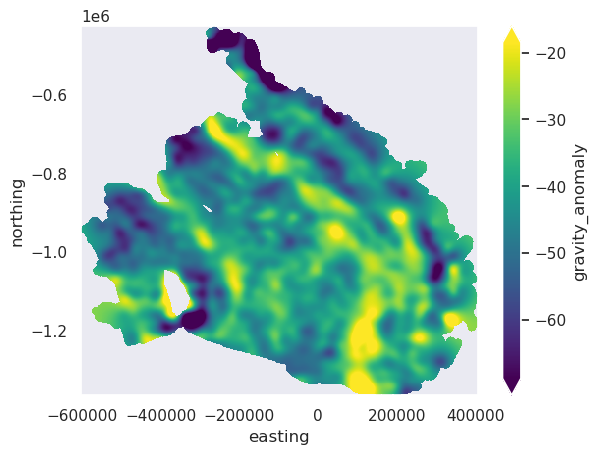

In [23]:
grav_df.set_index(["northing", "easting"]).to_xarray().Gobs.plot(robust=True)

In [12]:
# grav_grid = inv_utils.filter_grid(
#     grav_grid_full.Gobs,
#     50e3,
#     filt_type="lowpass",
# )

# grav_grid = grav_grid_full.Gobs

# print(utils.get_grid_info(grav_grid))

# grav_grid.plot()

In [13]:
# grav = vd.grid_to_table(grav_grid_full)
# grav = grav[grav.Gobs.notna()]
# # grav["upward"] = 1000
# grav.describe()

# Topo-free gravity disturbance

Start by filling everything above ellipsoid with ice, and everything below with water. Then correct the remaining anomalous masses relative to ice if above ellipsoid, or relative to water if below ellipsoid.

In [26]:
# ice prisms
density_contrast = ice_density - air_density
zref = 0
density_grid = xr.where(
    surface_layer_spacing >= zref, density_contrast, -density_contrast
)
ice_surface_prisms = utils.grids_to_prisms(
    surface_layer_spacing,
    zref,
    density=density_grid,
)

# water prisms
density_contrast = water_density - ice_density
zref = 0
density_grid = xr.where(
    icebase_layer_spacing >= zref, density_contrast, -density_contrast
)
water_surface_prisms = utils.grids_to_prisms(
    icebase_layer_spacing,
    zref,
    density=density_grid,
)

# sediment prisms
density_contrast = sediment_density - water_density
zref = 0
density_grid = xr.where(starting_bed >= zref, density_contrast, -density_contrast)
starting_bed_prisms = utils.grids_to_prisms(
    starting_bed,
    zref,
    density=density_grid,
)

# save starting bed prisms to zarr to use in inversion
enc = {x: {"compressor": zarr.Blosc()} for x in starting_bed_prisms}
starting_bed_prisms.to_zarr(
    "../../inversion_layers/RIS_starting_bed_prisms_mean.zarr",
    # "../../inversion_layers/RIS_starting_bed_prisms_verde_spline.zarr",
    # "../../inversion_layers/RIS_starting_bed_prisms_gmt_surface.zarr",
    encoding=enc,
    mode="w",
)

Number of ice surface prisms: 47089
Number of water surface prisms: 47089
Number of bed prisms: 47089


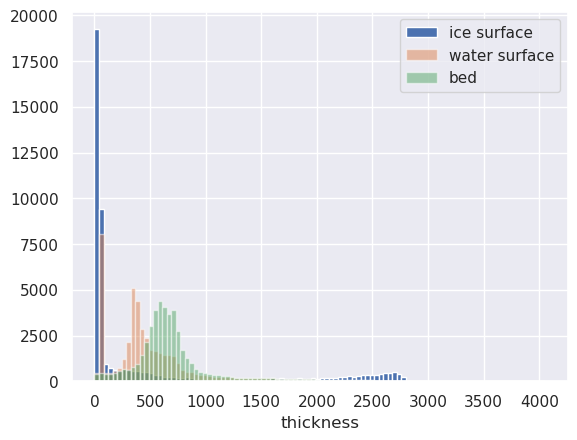

In [29]:
_ = ice_surface_prisms.thickness.plot.hist(bins=100, label="ice surface")
_ = water_surface_prisms.thickness.plot.hist(bins=100, alpha=0.5, label="water surface")
_ = starting_bed_prisms.thickness.plot.hist(bins=100, alpha=0.5, label="bed")

print(
    "Number of ice surface prisms:",
    len(
        ice_surface_prisms.thickness.values[
            ~np.isnan(ice_surface_prisms.thickness.values)
        ]
    ),
)
print(
    "Number of water surface prisms:",
    len(
        water_surface_prisms.thickness.values[
            ~np.isnan(water_surface_prisms.thickness.values)
        ]
    ),
)
print(
    "Number of bed prisms:",
    len(
        starting_bed_prisms.thickness.values[
            ~np.isnan(starting_bed_prisms.thickness.values)
        ]
    ),
)

plt.legend()

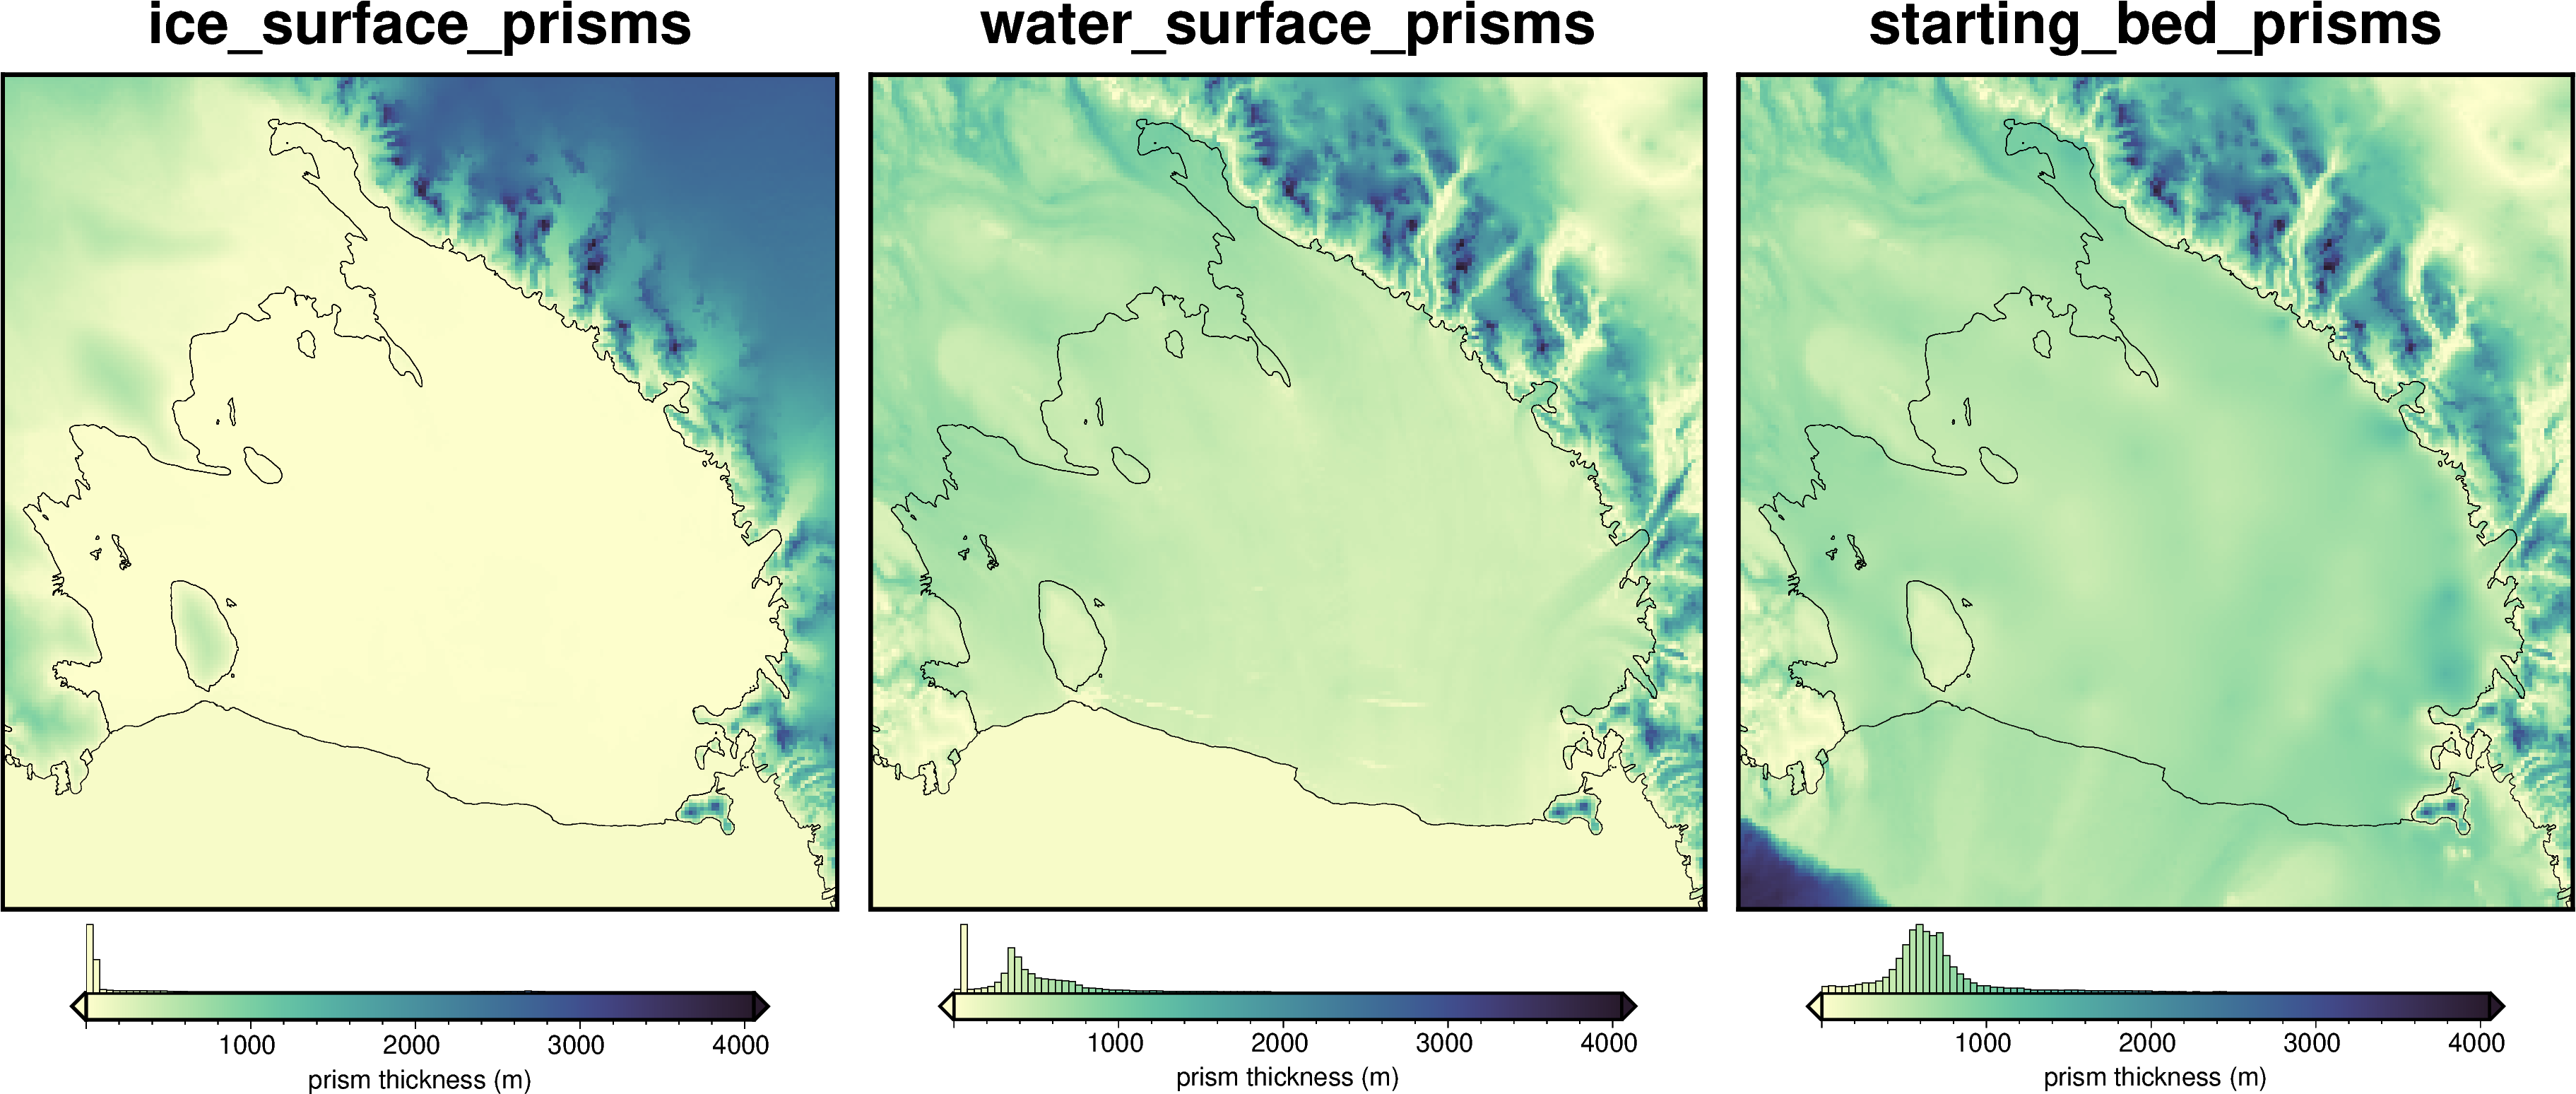

In [31]:
fig = maps.plot_grd(
    ice_surface_prisms.thickness,
    fig_height=10,
    coast=True,
    coast_pen="0.2p,black",
    title="ice_surface_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
)

fig = maps.plot_grd(
    water_surface_prisms.thickness,
    fig_height=10,
    coast=True,
    coast_pen="0.2p,black",
    title="water_surface_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
    fig=fig,
    origin_shift="xshift",
)

fig = maps.plot_grd(
    starting_bed_prisms.thickness,
    fig_height=10,
    coast=True,
    coast_pen="0.2p,black",
    title="starting_bed_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
    fig=fig,
    origin_shift="xshift",
)

fig.show()

## Calculate gravity

In [32]:
# calculate forward gravity of prisms
grav_df["ice_surface_grav"] = ice_surface_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df["water_surface_grav"] = water_surface_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df["starting_gravity"] = starting_bed_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df.describe()

  0%|          | 0/86037 [00:00<?, ?it/s]

  0%|          | 0/86037 [00:00<?, ?it/s]

  0%|          | 0/86037 [00:00<?, ?it/s]

,northing,easting,upward,gravity_anomaly,ice_surface_grav,water_surface_grav,starting_gravity
count,8.603700e+04,86037.000000,86037.0,86037.000000,86037.000000,86037.000000,86037.000000
mean,-9.807459e+05,-69100.212699,1000.0,-41.677259,0.413689,-1.814563,-32.552779
std,1.971350e+05,241608.797229,0.0,12.813560,3.028945,0.826919,10.977720
min,-1.365000e+06,-602500.000000,1000.0,-229.146031,-13.606799,-5.921153,-69.447055
25%,-1.137500e+06,-250000.000000,1000.0,-48.089621,-0.555179,-2.148036,-38.147759
50%,-9.925000e+05,-62500.000000,1000.0,-40.908668,-0.311427,-1.732806,-33.046278
75%,-8.425000e+05,125000.000000,1000.0,-34.377232,0.346025,-1.539245,-28.634751
max,-4.250000e+05,405000.000000,1000.0,3.452264,36.595176,4.137267,47.933471


## Correct the observed gravity

In [34]:
grav_df["partial_topo_corrected_disturbance"] = (
    grav_df.Gobs - grav_df.ice_surface_grav - grav_df.water_surface_grav
)

grav_df.describe()

,northing,easting,upward,Gobs,ice_surface_grav,water_surface_grav,starting_gravity,partial_topo_corrected_disturbance
count,8.603700e+04,86037.000000,86037.0,86037.000000,86037.000000,86037.000000,86037.000000,86037.000000
mean,-9.807459e+05,-69100.212699,1000.0,-41.677259,0.413689,-1.814563,-32.552779,-40.276385
std,1.971350e+05,241608.797229,0.0,12.813560,3.028945,0.826919,10.977720,13.287716
min,-1.365000e+06,-602500.000000,1000.0,-229.146031,-13.606799,-5.921153,-69.447055,-229.058790
25%,-1.137500e+06,-250000.000000,1000.0,-48.089621,-0.555179,-2.148036,-38.147759,-46.635158
50%,-9.925000e+05,-62500.000000,1000.0,-40.908668,-0.311427,-1.732806,-33.046278,-39.415229
75%,-8.425000e+05,125000.000000,1000.0,-34.377232,0.346025,-1.539245,-28.634751,-32.623399
max,-4.250000e+05,405000.000000,1000.0,3.452264,36.595176,4.137267,47.933471,-4.017115


## Calculate misfit (partial topo-corrected disturance - starting bed grav)  

## Save and load results

In [35]:
grav_df.to_csv(
    "../../data/RIS_topo_corrections_mean_bed.csv.gz",
    # "../../data/RIS_topo_corrections_verde_spline_levelled.csv.gz",
    # "../../data/RIS_topo_corrections_gmt_surface_levelled.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [7]:
grav_df = pd.read_csv(
    "../../data/RIS_topo_corrections_mean_bed.csv.gz",
    # "../../data/RIS_topo_corrections_verde_spline_levelled.csv.gz",
    # "../../data/RIS_topo_corrections_gmt_surface_levelled.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

grav_df.describe()

,northing,easting,upward,Gobs,ice_surface_grav,water_surface_grav,starting_gravity,partial_topo_corrected_disturbance
count,8.603700e+04,86037.000000,86037.0,86037.000000,86037.000000,86037.000000,86037.000000,86037.000000
mean,-9.807459e+05,-69100.212699,1000.0,-41.677259,0.413689,-1.814563,-32.552779,-40.276385
std,1.971350e+05,241608.797229,0.0,12.813560,3.028945,0.826919,10.977720,13.287716
min,-1.365000e+06,-602500.000000,1000.0,-229.146031,-13.606799,-5.921153,-69.447055,-229.058790
25%,-1.137500e+06,-250000.000000,1000.0,-48.089621,-0.555179,-2.148036,-38.147759,-46.635158
50%,-9.925000e+05,-62500.000000,1000.0,-40.908668,-0.311427,-1.732806,-33.046278,-39.415229
75%,-8.425000e+05,125000.000000,1000.0,-34.377232,0.346025,-1.539245,-28.634751,-32.623399
max,-4.250000e+05,405000.000000,1000.0,3.452264,36.595176,4.137267,47.933471,-4.017115


# Regional - Residual seperation

The `corrected observed gravity` is the combination of the signal from the density contrasts of `bathymetry` and `basement`. Both of these signals contain long-wavelength components, since both surface have long-wavelength topographic features. The `bathymetry` signal also contains short-wavelength components. Deeper in the crust, further away from the gravity observation points, these short-wavelength components decrease in amplitude. This means the majority the short-wavelength signal in the `corrected observed gravity` is resulting from the density contrast of the `bathymetry`. This is the signal we want to isolate and input into the inversion. 

To do this, we need to seperate the gravity misfit into a `regional` component and a `residual` component. This `regional` field should theoretically contain every gravity signal other than the that resulting from the `bathymetry` surface. Additionaly, this `residual` component should theoretically represent the gravity anomaly due to the difference between the true `bathymetry` and the low-resolution `bathymetry`. 

If we fail to accurately remove the `regional` signal, the resulting `bathymetry` after the inversion will contain long-wavelength topography, resulting from the `regional` gravity field.  

In [8]:
grav_df["gravity_anomaly"] = grav_df.partial_topo_corrected_disturbance

In [9]:
constraints

,northing,easting,upward,inside,uncert,weights
1744,-1.420000e+06,-580000.000000,-3480.743652,False,10.000000,0.010000
1745,-1.420000e+06,-575000.000000,-3485.402344,False,10.000000,0.010000
1746,-1.420000e+06,-570000.000000,-3478.737793,False,10.000000,0.010000
1747,-1.420000e+06,-565000.000000,-3474.053955,False,10.000000,0.010000
1748,-1.420000e+06,-560000.000000,-3444.883789,False,10.000000,0.010000
...,...,...,...,...,...,...
28082,-8.164639e+05,-218050.118799,-564.000000,True,28.163959,0.001261
28083,-1.087485e+06,-452466.872984,-714.000000,True,35.974822,0.000773
28084,-1.033177e+06,-214445.845201,-512.000000,True,25.265698,0.001567
28085,-8.266453e+05,-197189.312136,-583.000000,True,29.301911,0.001165


In [53]:
# use the constraints to find the best regional field
regional_grav_kwargs = dict(
    method="constraints",
    constraints_df=constraints,  # [constraints.inside],
    constraints_weights_column="weights",
    grid_method="eq_sources",
    damping=10,
    # cv=True,
    # cv_kwargs=dict(
    #     n_trials=20,
    #     damping_limits=(1e-20, 10),
    #     progressbar=True,
    #     fname="tmp_regional_sep",
    # ),
    constraints_block_size=layer_spacing,
    depth="default",
    block_size=layer_spacing,
    # grid_method="pygmt",
    # tension_factor=1,
    # grid_method="verde",
    # spline_dampings=[None, 1e-10, 1e-5, 1e-1, 10],
)

grav_df = regional.regional_separation(
    grav_df=grav_df,
    **regional_grav_kwargs,
)
grav_df.describe()

,northing,easting,upward,Gobs,ice_surface_grav,water_surface_grav,starting_gravity,partial_topo_corrected_disturbance,gravity_anomaly,misfit,res,reg
count,8.603700e+04,86037.000000,86037.0,86037.000000,86037.000000,86037.000000,86037.000000,86037.000000,86037.000000,86037.000000,86037.000000,86037.000000
mean,-9.807459e+05,-69100.212699,1000.0,-41.677259,0.413689,-1.814563,-32.552779,-40.276385,-40.276385,-7.723607,0.017333,-7.740940
std,1.971350e+05,241608.797229,0.0,12.813560,3.028945,0.826919,10.977720,13.287716,13.287716,17.817322,14.471208,20.889502
min,-1.365000e+06,-602500.000000,1000.0,-229.146031,-13.606799,-5.921153,-69.447055,-229.058790,-229.058790,-175.921304,-89.040832,-119.242030
25%,-1.137500e+06,-250000.000000,1000.0,-48.089621,-0.555179,-2.148036,-38.147759,-46.635158,-46.635158,-14.472935,-5.473390,-14.417202
50%,-9.925000e+05,-62500.000000,1000.0,-40.908668,-0.311427,-1.732806,-33.046278,-39.415229,-39.415229,-5.813202,-0.087543,-6.029479
75%,-8.425000e+05,125000.000000,1000.0,-34.377232,0.346025,-1.539245,-28.634751,-32.623399,-32.623399,1.922622,4.920540,2.238478
max,-4.250000e+05,405000.000000,1000.0,3.452264,36.595176,4.137267,47.933471,-4.017115,-4.017115,42.031207,91.146667,58.181830


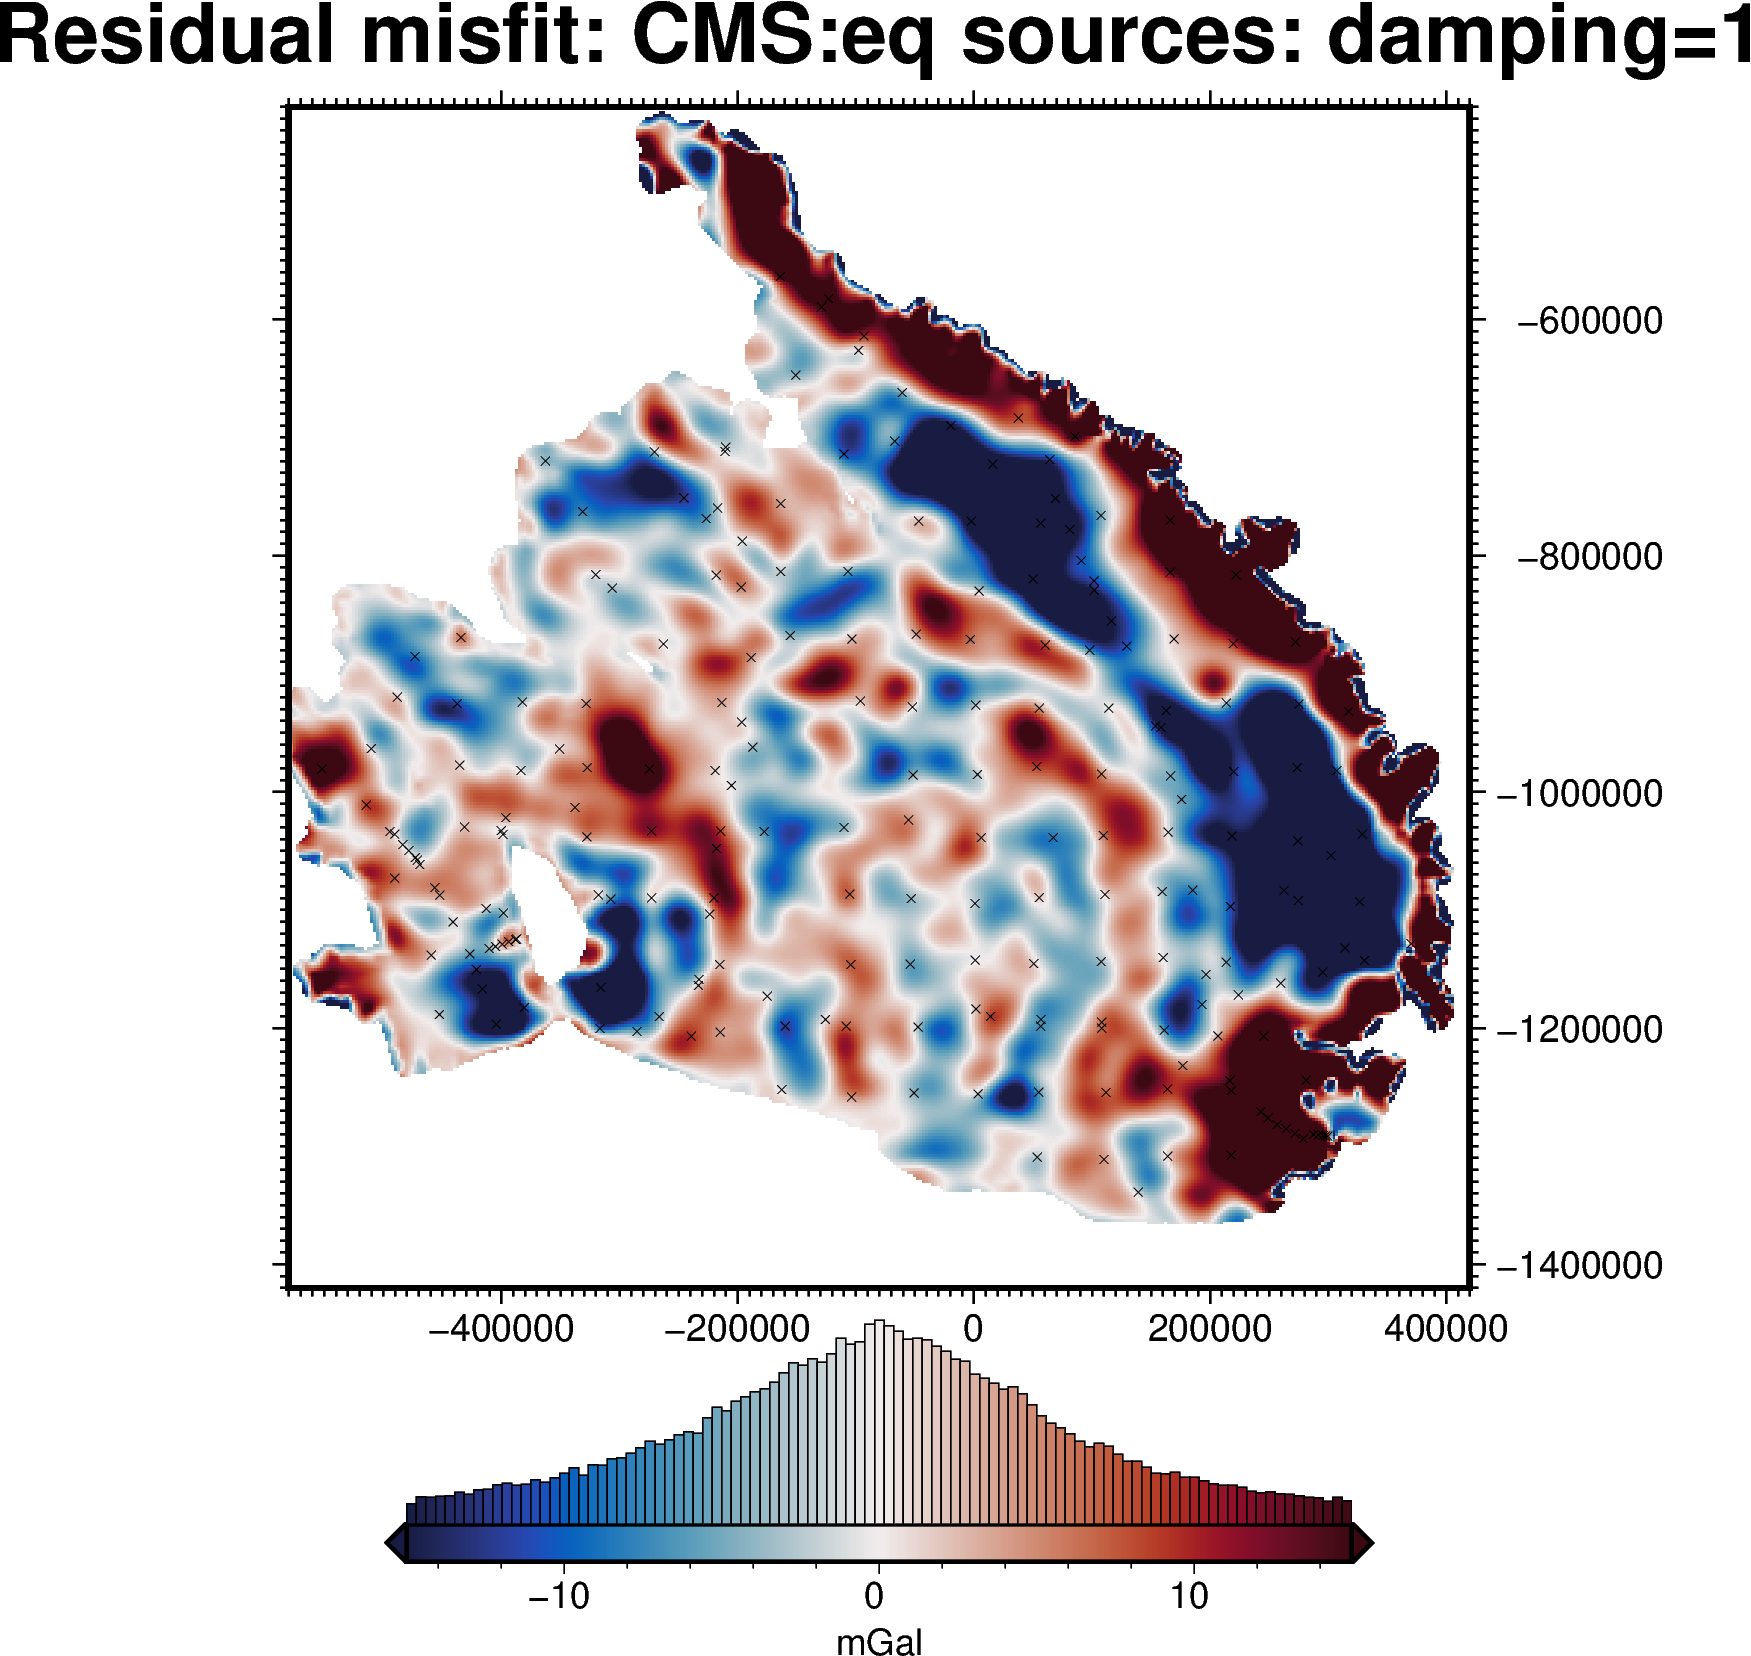

In [54]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# maxabs = vd.maxabs(polar_utils.get_min_max(grav_grid.res, robust=True))
maxabs = min(np.abs(polar_utils.get_min_max(grav_grid.res, robust=True)))
cpt_lims = [-maxabs, maxabs]
fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig_height=10,
    title="Residual misfit: CMS:eq sources: damping=1",
    cmap="balance+h0",
    # cpt_lims=cpt_lims,
    cpt_lims=[-15, 15],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraints[constraints.inside],
    points_style="x.1c",
    points_pen=".1p",
)
fig.show()

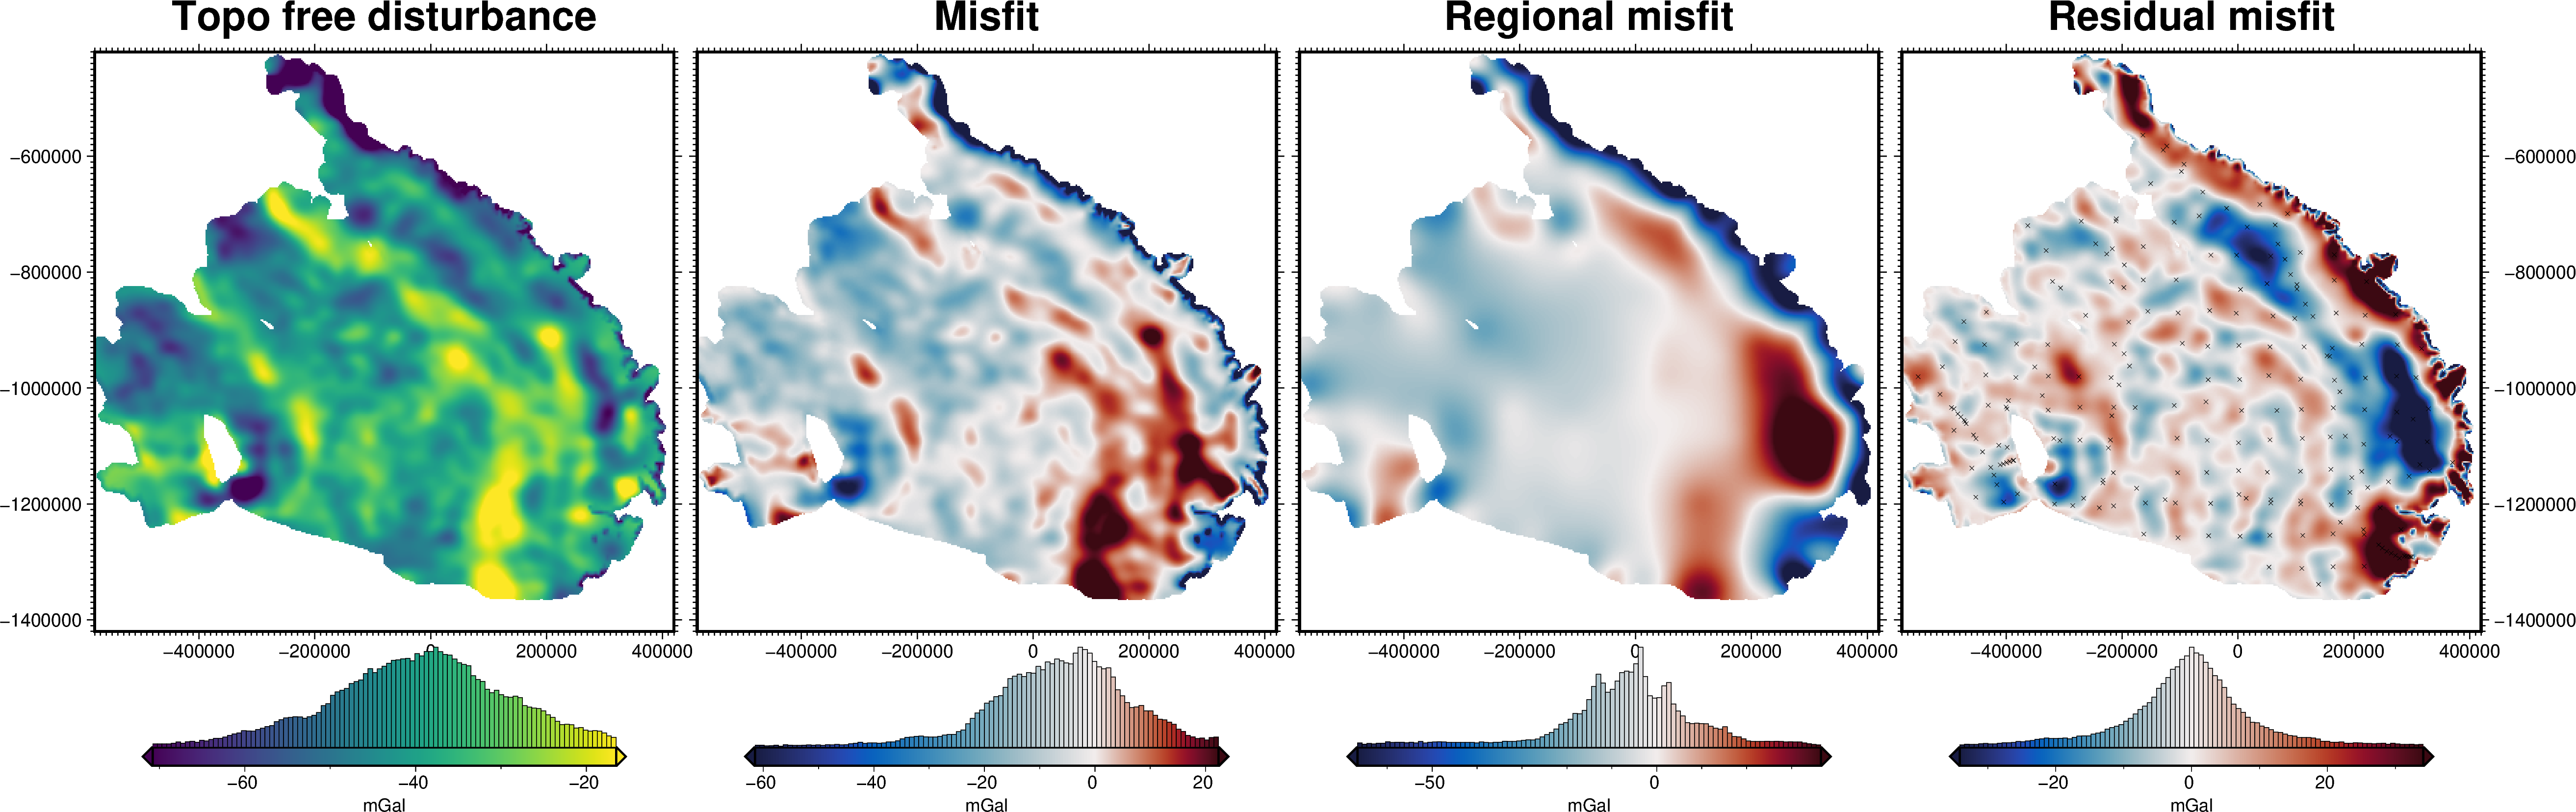

In [55]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Topo free disturbance",
    cmap="viridis",
    hist=True,
    robust=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="balance+h0",
    hist=True,
    robust=True,
    cbar_label="mGal",
    frame=["nSwe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="balance+h0",
    hist=True,
    robust=True,
    cbar_label="mGal",
    frame=["nSwe", "xaf10000", "yaf10000"],
)

# maxabs = vd.maxabs(polar_utils.get_min_max(grav_grid.res, robust=True))
maxabs = min(np.abs(polar_utils.get_min_max(grav_grid.res, robust=True)))
cpt_lims = [-maxabs, maxabs]
fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=cpt_lims,
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraints[constraints.inside],
    points_style="x.1c",
    points_pen=".1p",
)
fig.show()

### Save and load results

In [57]:
grav_df.to_csv(
    "../../data/RIS_topo_corrections_levelled_mean_bed.csv.gz",
    # "../../data/RIS_topo_corrections_levelled_verde_spline.csv.gz",
    # "../../data/RIS_topo_corrections_levelled_gmt_surface.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [58]:
grav_df = pd.read_csv(
    "../../data/RIS_topo_corrections_levelled_mean_bed.csv.gz",
    # "../../data/RIS_topo_corrections_levelled_verde_spline.csv.gz",
    # "../../data/RIS_topo_corrections_levelled_gmt_surface.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

grav_df

,northing,easting,test,upward,Gobs,ice_surface_grav,water_surface_grav,starting_gravity,partial_topo_corrected_disturbance,gravity_anomaly,misfit,res,reg
0,-1365000.0,147500.0,True,1000.0,-22.224204,-2.032832,-0.271643,-40.621666,-19.919730,-19.919730,20.701936,-1.178854,21.880791
1,-1365000.0,150000.0,False,1000.0,-23.445499,-2.032213,-0.272149,-40.756050,-21.141137,-21.141137,19.614914,-1.099532,20.714446
2,-1365000.0,152500.0,True,1000.0,-24.627477,-2.031659,-0.272576,-40.719744,-22.323241,-22.323241,18.396502,-1.146143,19.542645
3,-1365000.0,155000.0,False,1000.0,-25.746585,-2.031174,-0.272918,-40.616300,-23.442493,-23.442493,17.173807,-1.204360,18.378167
4,-1365000.0,157500.0,True,1000.0,-26.784923,-2.030756,-0.273174,-40.396296,-24.480992,-24.480992,15.915304,-1.316849,17.232153
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86032,-427500.0,-262500.0,True,1000.0,-54.725135,6.303262,-2.854799,-33.450664,-58.173598,-58.173598,-24.722934,-13.519063,-11.203871
86033,-427500.0,-260000.0,True,1000.0,-56.168581,7.206653,-2.832973,-33.195793,-60.542261,-60.542261,-27.346468,-13.532749,-13.813719
86034,-427500.0,-257500.0,True,1000.0,-57.593979,8.139829,-2.768730,-32.444078,-62.965078,-62.965078,-30.521000,-13.946845,-16.574156
86035,-425000.0,-265000.0,False,1000.0,-52.813303,6.107037,-2.079244,-24.367030,-56.841095,-56.841095,-32.474065,-22.719755,-9.754310


# Plots

In [ ]:
# lines = profiles.draw_lines()

In [ ]:
# # get clicked points
# # df = utils.shapes_to_df(lines)
# # # extract first and last
# # a = (df.x.iloc[0], df.y.iloc[0])
# # b = (df.x.iloc[-1], df.y.iloc[-1])

# # # siple coast
# # a, b = ((-514139.22589550324, -886012.3396426054),
# # (-30871.591933855758, -595196.2984418197))

# # # ice front to CIR
# # a,b = ((48403.646330947464, -1387918.0291082778),
# #  (-221877.26567443524, -613795.4844574957))

# # # Roosevelt Island to TAM
# # a,b = ((-489471.998996549, -1177190.3876565588),
# #  (190464.00058142765, -777830.3659641005))

# # # KIS to Ross Island
# # a,b = ((-391311.08538905036, -713591.4759308188),
# # (288280.6584588745, -1311607.5333427137))

# # South of Roosevelt to TAM
# a,b = ((-571375.4234697601, -1051511.5422168665),
#  (132779.8923736067, -719735.4502564461))
# a,b

In [ ]:
# grav_grids = df_anomalies[df_anomalies.test == False].set_index(["northing", "easting"]).to_xarray()

# # extract layers for profiles plot
# topo_grids = [
#     surface,
#     icebase,
#     starting_bed,
# ]
# topo_names = [
#     "ice surface",
#     "ice base",
#     "bed",
# ]

# data_grids = [
#     # grav_grids.ice_surface_grav + grav_grids.water_surface_grav,
#     grav_grids.misfit,
#     grav_grids.reg,
#     grav_grids.res,
#     # starting_bed_prisms.weights
# ]

# data_names = [
#     # "Ice and Water effects",
#     "Topo-corrected disturbance",
#     "Regional",
#     "Residual",
#     # "Weighting grid",
# ]

# layers_dict = profiles.make_data_dict(
#     names=topo_names,
#     grids=topo_grids,
#     colors=["lightskyblue", "darkblue", "lightbrown"],
# )

# data_dict = profiles.make_data_dict(
#     names=data_names,
#     grids=data_grids,
#     colors=[
#         # "cyan",
#         "red",
#         "black",
#         "blue",
#         # "purple",
#     ],
#     axes = [0,0,0,1],
# )

In [ ]:
# fig, _, _ = profiles.plot_profile(
#     "points",
#     start=a,
#     stop=b,
#     num=1000,
#     # add_map=True,
#     map_buffer=0.2,
#     subplot_orientation="horizontal",
#     # subplot_orientation='vertical',
#     data_dict=data_dict,
#     layers_dict=layers_dict,
#     share_yaxis=True,
#     map_points=constraints[constraints.inside].rename(
#         columns={"easting": "x", "northing": "y"}
#     ),
#     data_height=5,
# )
# fig.show()

In [ ]:
# grav_grids = (
#     df_anomalies[df_anomalies.test == False].set_index(["northing", "easting"]).to_xarray()
# )

# grids = [
#     grav_grids.misfit,
#     grav_grids.reg,
#     grav_grids.res,
# ]

# titles = [
#     "Topo-corrected disturbance",
#     "Regional",
#     "Residual",

# ]

# # lims = [utils.get_min_max(i, robust=True) for i in grids]
# # lims = [min([i for i in lims[0]]), max([i for i in lims[1]])]
# # lims = utils.get_min_max(grids[2])

# for i, g in enumerate(grids):
#     if i == 0:
#         fig = None
#         origin_shift = "initialize"
#         xshift_amount = 1
#     else:
#         fig = fig
#         origin_shift = "xshift"
#         xshift_amount = 1

#     if i == 2:
#         cmap = "balance+h0"
#         robust = False
#     else:
#         cmap = "viridis"
#         robust = True
#     # cmap = "viridis"

#     fig = maps.plot_grd(
#         fetch.modis_moa(),
#         image=True,
#         cmap="gray",
#         region=inversion_region,
#         fig_height=10,
#         transparency=50,
#         fig=fig,
#         origin_shift=origin_shift,
#         xshift_amount=xshift_amount,
#         yshift_amount=yshift_amount,
#     )

#     fig = maps.plot_grd(
#         grid=g,
#         fig_height=10,
#         region=inversion_region,
#         coast=True,
#         coast_type="measures-v2",
#         region=inversion_region,
#         # cmap=f"vik+h{np.nanmedian(g)}",
#         cmap=cmap,
#         robust=robust,
#         title=titles[i],
#         cbar_label="mGal",
#         points=constraints[constraints.inside].rename(
#             columns={"easting": "x", "northing": "y"}
#         ),
#         points_style="x0.05c",
#         hist=True,
#         cbar_yoffset=1,
#         fig=fig,
#         origin_shift="no_shift",
#     )
#     fig.text(
#         position="TL",
#         justify="BL",
#         text=f"{string.ascii_lowercase[i]})",
#         font="20p,Helvetica,black",
#         offset="j0/.3",
#         no_clip=True,
#     )

#     if i == 1:
#         # plot profiles location, and endpoints on map
#         fig.plot(
#             vd.line_coordinates(a, b, size=100),
#             pen="2p,black",
#         )
#         fig.text(
#             x=a[0],
#             y=a[1],
#             text="A",
#             fill="white",
#             font="12p,Helvetica,black",
#             justify="CM",
#             clearance="+tO",
#         )
#         fig.text(
#             x=b[0],
#             y=b[1],
#             text="B",
#             fill="white",
#             font="12p,Helvetica,black",
#             justify="CM",
#             clearance="+tO",
#         )
# fig.show()

# Corrections as contrasts (zref=0)

## Surface prisms

In [ ]:
# # create prisms around surface
# # positive densities above reference, negative below
# density = ice_density - air_density
# print(f"Surface density contrast: {density}kgm-3")

# zref = np.nanmean(surface)
# # zref = 0
# surface_prisms = inv_utils.grids_to_prisms(
#     surface=surface,
#     reference=zref,
#     density=xr.where(surface >= zref, density, -density),
#     input_coord_names=["x", "y"],
# )

## Icebase prisms

In [ ]:
# # create prisms around icebase
# # positive densities above reference, negative below
# density = water_density - ice_density
# print(f"Icebase density contrast: {density}kgm-3")

# zref = np.nanmean(icebase)
# # zref = 0
# icebase_prisms = inv_utils.grids_to_prisms(
#     surface=icebase,
#     reference=zref,
#     density=xr.where(icebase >= zref, density, -density),
#     input_coord_names=["x", "y"],
# )

## Starting bed prisms

In [ ]:
# # create prisms around bed
# # positive densities above reference, negative below
# density = sediment_density - water_density
# print(f"Bed density contrast: {density}kgm-3")

# zref = np.nanmean(starting_bed)
# # zref = 0
# bed_prisms = inv_utils.grids_to_prisms(
#     surface=starting_bed,
#     reference=zref,
#     density=xr.where(starting_bed >= zref, density, -density),
#     input_coord_names=["x", "y"],
# )

In [ ]:
# # calculate forward gravity
# forward_grav_grid, forward_grav_df = inv_utils.forward_grav_of_prismlayer(
#     [surface_prisms, icebase_prisms, bed_prisms],
#     grav_df,
#     names=["surface_prisms", "icebase_prisms", "bed_prisms"],
#     progressbar=True,
#     plot=False,
# )

# grav_df["surface_forward"] = forward_grav_df.surface_prisms
# grav_df["icebase_forward"] = forward_grav_df.icebase_prisms
# grav_df["bed_forward"] = forward_grav_df.bed_prisms

# grav_df.describe()

## Correct the observed gravity

In [ ]:
# grav_df["terrain_effect"] = grav_df.surface_forward + grav_df.icebase_forward

# grav_df["Gobs_corr_contrasts"] = grav_df.Gobs - grav_df.terrain_effect

# grav_df.describe()

## Misfit

In [ ]:
# grav_df = inv.misfit(
#     input_grav=grav_df,
#     input_forward_column="bed_forward",
#     input_grav_column="Gobs_corr_contrasts",
#     constraints=constraints,
# )

# # grav_df["total_misfit"] = grav_df.Gobs_corr - grav_df.bed_forward
# grav_df.describe()

## Save and load results

In [ ]:
# grav_df.to_csv(
#     "../data/RIS_topo_corrections.csv.gz",
#     sep=",",
#     na_rep="",
#     header=True,
#     index=False,
#     encoding="utf-8",
#     compression="gzip",
# )

In [ ]:
# grav_df = pd.read_csv(
#     "../data/RIS_topo_corrections.csv.gz",
#     sep=",",
#     header="infer",
#     index_col=None,
#     compression="gzip",
# )

# grav_df.describe()

# Stripping masses

In [28]:
ice_prisms = inv_utils.grids_to_prisms(
    surface=surface_layer_spacing,
    reference=icebase_layer_spacing,
    density=ice_density,
)

water_prisms = inv_utils.grids_to_prisms(
    surface=icebase_layer_spacing,
    reference=starting_bed,
    density=water_density,
)

earth_prisms = inv_utils.grids_to_prisms(
    surface=starting_bed,
    reference=np.nanmin(starting_bed),
    density=sediment_density,
)

Number of ice prisms: 47089
Number of water prisms: 47089
Number of earth prisms: 47089


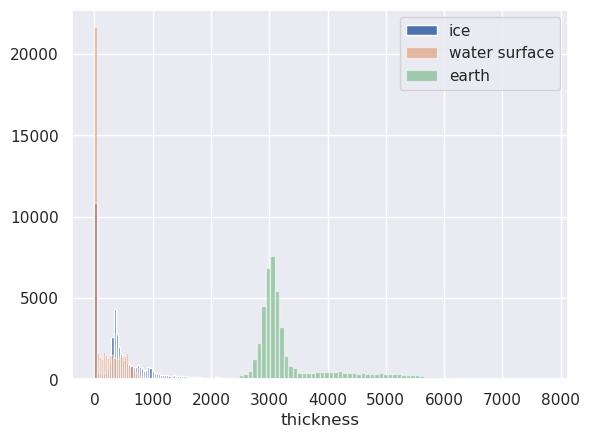

In [29]:
_ = ice_prisms.thickness.plot.hist(bins=100, label="ice")
_ = water_prisms.thickness.plot.hist(bins=100, alpha=0.5, label="water surface")
_ = earth_prisms.thickness.plot.hist(bins=100, alpha=0.5, label="earth")


print(
    "Number of ice prisms:",
    len(ice_prisms.thickness.values[~np.isnan(ice_prisms.thickness.values)]),
)
print(
    "Number of water prisms:",
    len(water_prisms.thickness.values[~np.isnan(water_prisms.thickness.values)]),
)
print(
    "Number of earth prisms:",
    len(earth_prisms.thickness.values[~np.isnan(earth_prisms.thickness.values)]),
)

plt.legend()

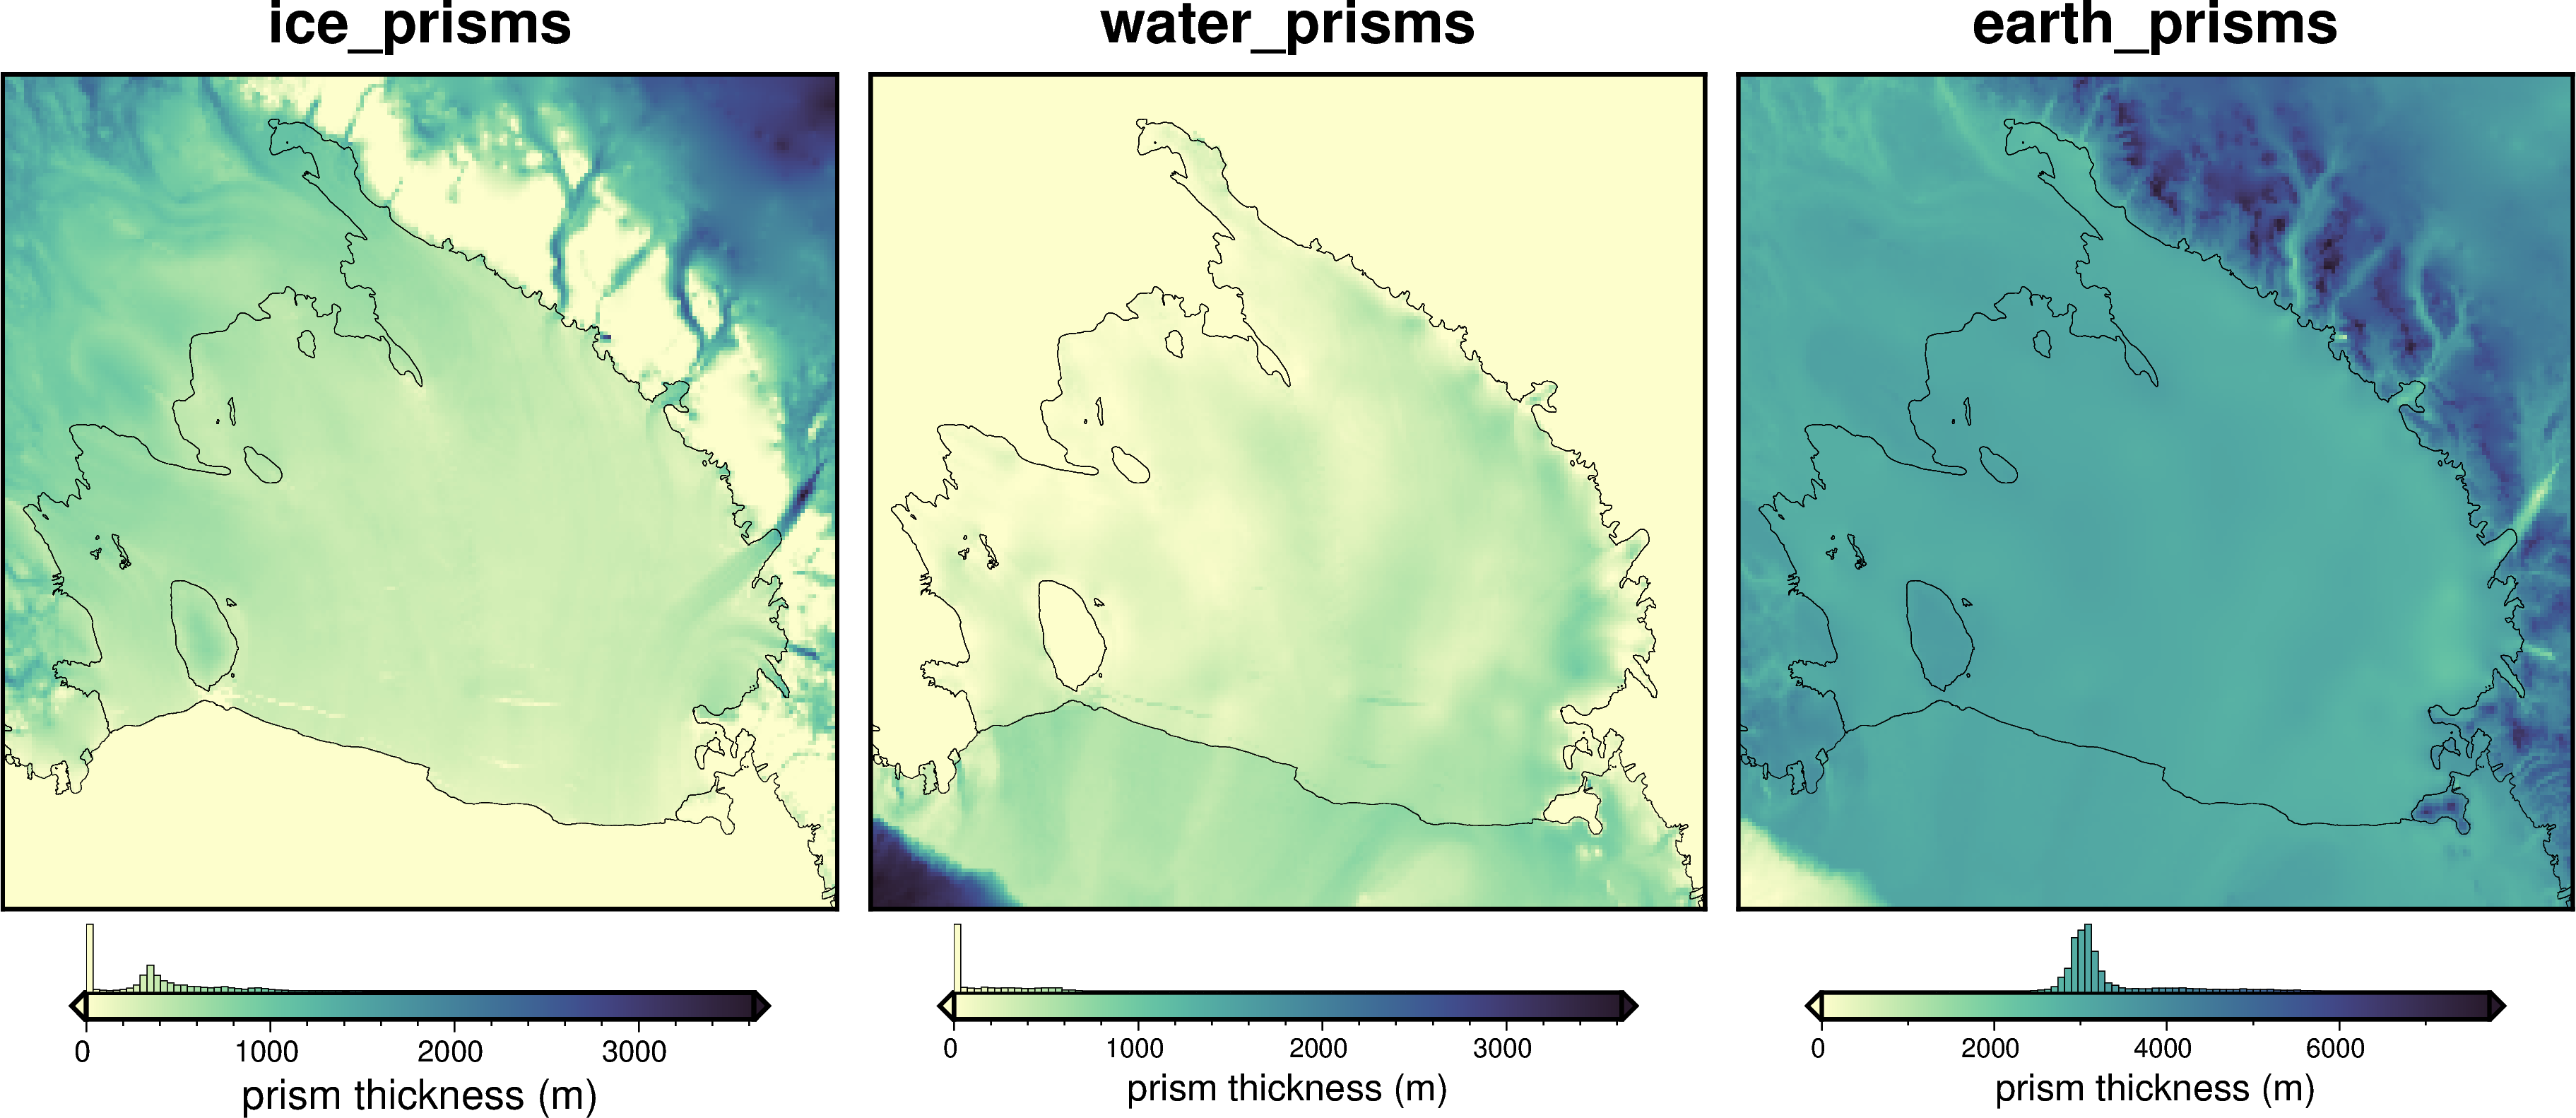

In [30]:
fig = maps.plot_grd(
    ice_prisms.thickness,
    fig_height=10,
    coast=True,
    coast_pen="0.2p,black",
    title="ice_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
)

fig = maps.plot_grd(
    water_prisms.thickness,
    fig_height=10,
    coast=True,
    coast_pen="0.2p,black",
    title="water_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
    fig=fig,
    origin_shift="xshift",
)

fig = maps.plot_grd(
    earth_prisms.thickness,
    coast=True,
    coast_pen="0.2p,black",
    title="earth_prisms",
    cbar_label="prism thickness (m)",
    cmap="deep",
    hist=True,
    cbar_yoffset=1,
    fig=fig,
    origin_shift="xshift",
)

fig.show()

## Calculate gravity

In [31]:
# calculate gravity of prisms
forward_grid, forward_df = inv_utils.forward_grav_of_prismlayer(
    [
        ice_prisms,
        water_prisms,
        earth_prisms,
    ],
    df_anomalies,
    names=[
        "ice_prisms",
        "water_prisms",
        "earth_prisms",
    ],
    # thickness_threshold=1,
    progressbar=True,
    plot=False,
)

df_anomalies["ice_grav"] = forward_df.ice_prisms
df_anomalies["water_grav"] = forward_df.water_prisms
df_anomalies["earth_grav"] = forward_df.earth_prisms

df_anomalies.describe()

  0%|                                                 | 0/85914 [00:00<?, ?it/s]

  0%|                                                 | 0/85914 [00:00<?, ?it/s]

  0%|                                                 | 0/85914 [00:00<?, ?it/s]

,northing,easting,upward,Gobs,ice_surface_grav,water_surface_grav,starting_bed_grav,partial_topo_corrected_disturbance,misfit,reg,res,ice_grav,water_grav,earth_grav,stripping_effect_as_masses,stripped_disturbance_as_masses,terrain_effect
count,8.591400e+04,85914.000000,85914.0,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85791.000000,85791.000000,85914.000000
mean,-9.807940e+05,-68355.244780,1000.0,-41.635424,0.408694,-1.813703,-34.632924,-40.230416,-5.597492,-6.007341,0.409849,15.634259,10.754372,290.540912,316.934023,-358.558505,-36.037933
std,1.972713e+05,240977.452181,0.0,12.642947,3.026426,0.826801,11.404587,13.100643,18.028138,17.471707,5.865073,6.466270,7.894227,20.546438,13.982327,17.947821,14.042317
min,-1.365000e+06,-580000.000000,1000.0,-222.110615,-13.612121,-5.920126,-71.203652,-222.023617,-168.856796,-143.524001,-53.431386,-5.860135,0.044136,224.104067,279.129731,-513.665554,-73.319443
25%,-1.140000e+06,-250000.000000,1000.0,-48.041755,-0.555447,-2.147006,-40.287556,-46.615006,-12.514437,-11.360050,-2.159865,12.429808,3.763737,280.163095,310.480183,-365.903190,-42.331807
50%,-9.925000e+05,-62500.000000,1000.0,-40.820589,-0.312206,-1.732367,-35.468362,-39.257963,-3.856370,-3.799498,0.004364,14.270318,9.712458,289.321731,315.712301,-357.062841,-37.553567
75%,-8.400000e+05,125000.000000,1000.0,-34.323489,0.340173,-1.538939,-30.573363,-32.639919,4.450478,3.291219,2.218660,18.406435,16.157813,298.196220,320.746025,-348.280154,-32.559759
max,-4.250000e+05,405000.000000,1000.0,1.997854,36.591922,4.137666,47.834677,-4.433789,36.900787,36.448793,82.099716,64.593578,37.543068,438.734348,440.592255,-314.531529,88.228553


## Correct the observed gravity

In [32]:
df_anomalies["stripping_effect_as_masses"] = (
    df_anomalies.ice_grav + df_anomalies.water_grav + df_anomalies.earth_grav
)

df_anomalies["stripped_disturbance_as_masses"] = (
    df_anomalies.Gobs - df_anomalies.stripping_effect_as_masses
)
df_anomalies.describe()

,northing,easting,upward,Gobs,ice_surface_grav,water_surface_grav,starting_bed_grav,partial_topo_corrected_disturbance,misfit,reg,res,ice_grav,water_grav,earth_grav,stripping_effect_as_masses,stripped_disturbance_as_masses,terrain_effect
count,8.591400e+04,85914.000000,85914.0,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000,85914.000000
mean,-9.807940e+05,-68355.244780,1000.0,-41.635424,0.408694,-1.813703,-34.632924,-40.230416,-5.597492,-6.007341,0.409849,15.634259,10.754372,290.540912,316.929543,-358.564967,-36.037933
std,1.972713e+05,240977.452181,0.0,12.642947,3.026426,0.826801,11.404587,13.100643,18.028138,17.471707,5.865073,6.466270,7.894227,20.546438,13.989464,17.924923,14.042317
min,-1.365000e+06,-580000.000000,1000.0,-222.110615,-13.612121,-5.920126,-71.203652,-222.023617,-168.856796,-143.524001,-53.431386,-5.860135,0.044136,224.104067,279.129731,-520.416073,-73.319443
25%,-1.140000e+06,-250000.000000,1000.0,-48.041755,-0.555447,-2.147006,-40.287556,-46.615006,-12.514437,-11.360050,-2.159865,12.429808,3.763737,280.163095,310.471697,-365.564027,-42.331807
50%,-9.925000e+05,-62500.000000,1000.0,-40.820589,-0.312206,-1.732367,-35.468362,-39.257963,-3.856370,-3.799498,0.004364,14.270318,9.712458,289.321731,315.706891,-356.851614,-37.553567
75%,-8.400000e+05,125000.000000,1000.0,-34.323489,0.340173,-1.538939,-30.573363,-32.639919,4.450478,3.291219,2.218660,18.406435,16.157813,298.196220,320.743823,-348.645349,-32.559759
max,-4.250000e+05,405000.000000,1000.0,1.997854,36.591922,4.137666,47.834677,-4.433789,36.900787,36.448793,82.099716,64.593578,37.543068,438.734348,440.592255,-314.761282,88.228553


In [33]:
df_anomalies["terrain_effect"] = (
    df_anomalies.ice_surface_grav
    + df_anomalies.water_surface_grav
    + df_anomalies.starting_bed_grav
)

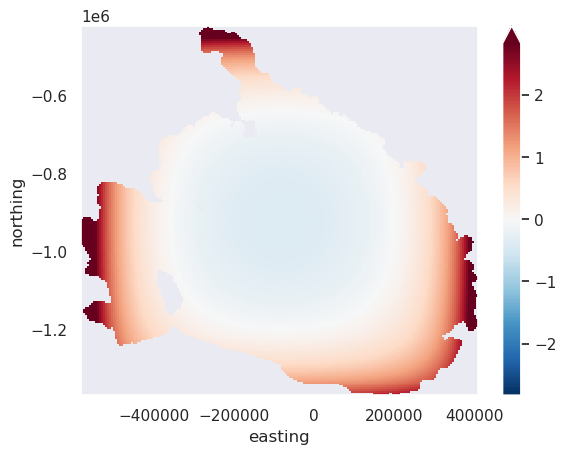

In [35]:
grav_grids = (
    df_anomalies[~df_anomalies.test].set_index(["northing", "easting"]).to_xarray()
)

offset = np.nanmedian(
    (grav_grids.terrain_effect) - grav_grids.stripping_effect_as_masses
)

stripping_centered = grav_grids.stripping_effect_as_masses + offset


dif = grav_grids.terrain_effect - stripping_centered

region = regions.ross_ice_shelf

dif = dif.sel(
    easting=slice(region[0], region[1]),
    northing=slice(region[2], region[3]),
)
dif.plot(robust=True)